Посмотрим на результат добавления признаков кластера и коэффициентов без данных о детской смертности.

> TODO - убрать этот файл

In [782]:
import sys
# Добавим папку с корнем проекта в список системных директорий, чтобы Python видел путь к папкам utils и classes
sys.path.append('..')

In [ ]:
from IPython.display import Markdown
import time
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import (
    MinMaxScaler, 
    PolynomialFeatures, 
    LabelBinarizer, 
    OneHotEncoder,
)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import (
    BaggingRegressor, 
    AdaBoostRegressor,
    StackingRegressor,
)
# библиотека для кодирования признаков
import category_encoders as ce

from utils.constants import (
    F, 
    RANDOM_STATE,
)
from utils.helpers import get_exec_time
from utils.graphics import (
    display_corellation_by_target,
)
from utils.display_content import (
    display_fields_correlation,
)
from utils.prepare_data import (
    get_location_codes,
    get_location_time_series,
    get_location_by_code,
    get_train_test_data,
    get_data_with_smoothing_target_feature,
    get_integration_order,
    get_predictors,
    get_train_test_split,
    get_location_data,
    get_formatted_time_series,
)
from classes.LocationCluster import LocationCluster
from classes.LocationCoef import LocationCoef


%matplotlib inline

from warnings import simplefilter
simplefilter('ignore')

In [784]:
# Загрузим таблицу
data_source = pd.read_csv(
    '../data/cumulative_life_expectancy_prepared.csv'
)

data_source.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,PositiveCoef,NegativeCoef,ImmunizationMean,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,1.11,7.66,563.733796,16194869.0,5.027188,1,0.839586,0.837126,28.000000,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,2.05,13.35,533.586202,16747208.0,5.092250,1,0.839586,0.837126,43.333333,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,1.31,11.54,882.147847,17327699.0,5.157312,1,0.839586,0.837126,42.666667,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,1.47,14.55,992.698979,17943712.0,5.222375,1,0.839586,0.837126,37.000000,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,1.69,21.36,1266.210864,18600423.0,5.287437,1,0.839586,0.837126,36.000000,52.36


In [785]:
# , 'ImmunizationMean'
data = data_source.drop(columns=['ClusterKMeans', 'PositiveCoef', 'NegativeCoef'])
# Разделим данные на тренировочные и тестовые
train_data_source, test_data_source = get_train_test_data(data)

train_data, test_data = get_data_with_smoothing_target_feature(
    train_data_source, test_data_source
)

In [786]:
test_data[F.Period.value].unique()

array([2018, 2019, 2020])

Добавим признак с кластером

In [787]:
cluster_creater = LocationCluster(2)
cluster_creater.fit(train_data)

train_data = cluster_creater.transform(train_data)
test_data = cluster_creater.transform(test_data)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,7.634211,2.013158,134.172105,174.930991,20130327.0,3.030,25.0,53.698636,1,53.82
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,7.777368,2.175789,147.827895,138.706822,20284307.0,3.088,35.0,54.494593,1,53.91


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,1.91,0.55,2.77,491.337221,36743039.0,5.338,68.666667,61.007708,1,60.49
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,1.78,0.50,2.48,496.602504,37856121.0,5.514,64.333333,61.182749,1,61.22


Добавим признаки с коэффициентами.

In [788]:
columns_to_exclude = [
    F.Period.value,
    F.Population.value, 
    F.AlcoholСonsumption.value,
    F.BmiAdultOverweight25.value,
    F.BmiAdultOverweight30.value,
    F.BmiChildOverweight1.value,
    F.BmiTeenagerOverweight1.value,
    F.BmiChildOverweight2.value,
    F.BmiTeenagerOverweight2.value,
    F.AdultNcdMortality061.value,
    F.AdultNcdMortality080.value,#
    F.AdultNcdMortalitySum.value,
    F.AdultNcdMortality110.value,
    F.AdultNcdMortality117.value,
    #F.ChildUnder5Mortality15.value,
    #F.ChildUnder5Mortality16.value,
    #F.ChildUnder5Mortality10.value,
    #F.ChildUnder5Mortality17.value,
]

coefs_creater = LocationCoef(columns_to_exclude)
coefs_creater.fit(train_data)

train_data = coefs_creater.transform(train_data)
test_data = coefs_creater.transform(test_data)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,134.172105,174.930991,20130327.0,3.030,25.0,53.698636,1,0.798514,0.875358,53.82
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,147.827895,138.706822,20284307.0,3.088,35.0,54.494593,1,0.798514,0.875358,53.91


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ImmunizationMean,SmoothingLifeExpectancy,ClusterKMeans,PositiveCoef,NegativeCoef,LifeExpectancy
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,2.77,491.337221,36743039.0,5.338,68.666667,61.007708,1,0.798514,0.875358,60.49
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,2.48,496.602504,37856121.0,5.514,64.333333,61.182749,1,0.798514,0.875358,61.22


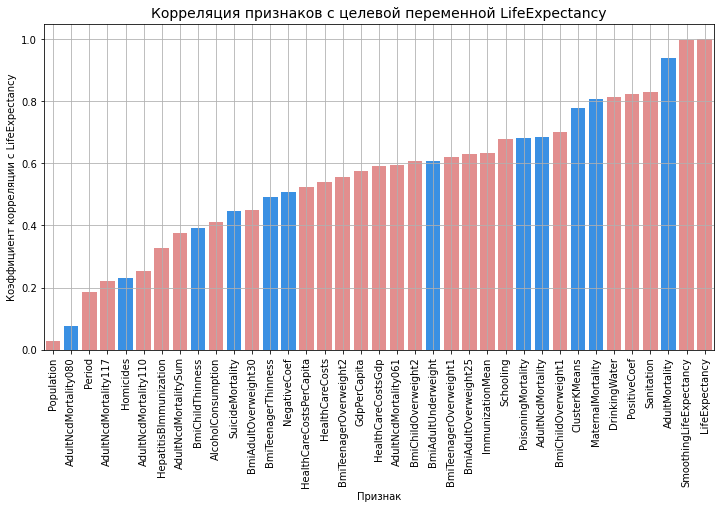

In [789]:
display_corellation_by_target(train_data)

Реализуем однократное кодирование кода региона \
И двоичное кодирование кода страны..

> TODO - через dummies это проще сделать \
`tempdf = pd.get_dummies(df, columns=categorylist)`

In [790]:
train_data['Reg'] = train_data[F.ParentLocationCode.value]
test_data['Reg'] = test_data[F.ParentLocationCode.value]

columns_to_encode = ['Reg']

# указываем столбец для кодирования
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(train_data[columns_to_encode])

bin_train = one_hot_encoder.transform(train_data[columns_to_encode]).toarray() 
bin_test = one_hot_encoder.transform(test_data[columns_to_encode]).toarray() 

column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)

bin_train = pd.DataFrame(bin_train, columns=column_names)
bin_test = pd.DataFrame(bin_test, columns=column_names)

train_data = pd.concat([train_data, bin_train], axis=1)
test_data = pd.concat([test_data, bin_test], axis=1)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,PositiveCoef,NegativeCoef,LifeExpectancy,Reg,Reg_AFR,Reg_AMR,Reg_EMR,Reg_EUR,Reg_SEAR,Reg_WPR
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,0.798514,0.875358,53.82,EMR,0.0,0.0,1.0,0.0,0.0,0.0
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,0.798514,0.875358,53.91,EMR,0.0,0.0,1.0,0.0,0.0,0.0


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,PositiveCoef,NegativeCoef,LifeExpectancy,Reg,Reg_AFR,Reg_AMR,Reg_EMR,Reg_EUR,Reg_SEAR,Reg_WPR
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,0.798514,0.875358,60.49,EMR,0.0,0.0,1.0,0.0,0.0,0.0
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,0.798514,0.875358,61.22,EMR,0.0,0.0,1.0,0.0,0.0,0.0


In [791]:
train_data['Loc'] = train_data[F.SpatialDimValueCode.value]
test_data['Loc'] = test_data[F.SpatialDimValueCode.value]
columns_to_encode = ['Loc']

bin_encoder = ce.BinaryEncoder(cols=columns_to_encode)
bin_encoder.fit(train_data[columns_to_encode])

bin_train = bin_encoder.transform(train_data[columns_to_encode])
bin_test = bin_encoder.transform(test_data[columns_to_encode])

train_data = pd.concat([train_data, bin_train], axis=1)
test_data = pd.concat([test_data, bin_test], axis=1)

display(train_data.head(2))
display(test_data.head(2))

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Reg_WPR,Loc,Loc_0,Loc_1,Loc_2,Loc_3,Loc_4,Loc_5,Loc_6,Loc_7
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2000,37.82,0.00978,1.346144,43.2,0.030243,...,0.0,AFG,0,0,0,0,0,0,0,1
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2001,38.03,0.00964,1.273431,43.5,0.031152,...,0.0,AFG,0,0,0,0,0,0,0,1


,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Reg_WPR,Loc,Loc_0,Loc_1,Loc_2,Loc_3,Loc_4,Loc_5,Loc_6,Loc_7
0,EMR,Eastern Mediterranean,AFG,Afghanistan,2018,30.80,0.00852,0.663428,34.6,0.021958,...,0.0,AFG,0,0,0,0,0,0,0,1
1,EMR,Eastern Mediterranean,AFG,Afghanistan,2019,29.38,0.00846,0.644273,34.4,0.021885,...,0.0,AFG,0,0,0,0,0,0,0,1


In [792]:
#display_corellation_by_target(train_data, figsize=(18,9))

In [793]:
train_data.columns

Index(['ParentLocationCode', 'ParentLocation', 'SpatialDimValueCode',
       'Location', 'Period', 'AdultMortality', 'Homicides',
       'MaternalMortality', 'AdultNcdMortality', 'AdultNcdMortality117',
       'AdultNcdMortality110', 'AdultNcdMortality080', 'AdultNcdMortality061',
       'AdultNcdMortalitySum', 'PoisoningMortality', 'SuicideMortality',
       'AlcoholСonsumption', 'HepatitisBImmunization', 'BmiAdultUnderweight',
       'BmiAdultOverweight25', 'BmiAdultOverweight30', 'BmiChildThinness',
       'BmiTeenagerThinness', 'BmiChildOverweight1', 'BmiTeenagerOverweight1',
       'BmiChildOverweight2', 'BmiTeenagerOverweight2', 'Sanitation',
       'DrinkingWater', 'HealthCareCosts', 'HealthCareCostsGdp',
       'HealthCareCostsPerCapita', 'GdpPerCapita', 'Population', 'Schooling',
       'ImmunizationMean', 'SmoothingLifeExpectancy', 'ClusterKMeans',
       'PositiveCoef', 'NegativeCoef', 'LifeExpectancy', 'Reg', 'Reg_AFR',
       'Reg_AMR', 'Reg_EMR', 'Reg_EUR', 'Reg_SEAR', 'R

In [794]:
def extract_optimal_features(data_source: pd.DataFrame) -> pd.DataFrame:
    """Оставляет в данных оптимальные признаки

    Args:
        data_source (pd.DataFrame): исходные данные

    Returns:
        pd.DataFrame: обработанные данные
    """
    # Копируем таблицу, чтобы не мутировать исходные данные
    data = data_source.copy()
    
    # Получим список предикторов (список полей для предсказания не включает данные о смертности)
    predictors = get_predictors(data)
    predictors = predictors + [
        'Reg_AFR', 'Reg_AMR', 'Reg_EMR', 'Reg_EUR', 'Reg_SEAR', 'Reg_WPR',  
        'Loc_0', 'Loc_1', 'Loc_2', 'Loc_3', 'Loc_4', 'Loc_5', 'Loc_6', 'Loc_7'
    ]
    # Оставим только предикторы и целевую переменную
    data = data[predictors + [F.LifeExpectancy.value]]    
    
    # Поля для удаления
    columns_to_drop = [
        'Reg_SEAR',
        'Loc_1',
        F.Population.value,
        'Reg_EMR',
        'Loc_3',
        'Loc_2',
        'Loc_6',
        'Reg_WPR',
        'Loc_4',
        'Loc_7',
        'Loc_0',
        'Loc_5',
        F.Period.value,
        # 0.5482896727664307
        'Reg_AMR',
        # 0.5481779293465979
        F.BmiAdultOverweight30.value,
        # 0.5486160004085506
        F.BmiChildOverweight2.value,
        # 0.5491220740321505
        F.BmiTeenagerOverweight1.value,
        # 0.549154441608663
        F.BmiChildThinness.value,
        # 0.5491559229132613
        F.HealthCareCostsPerCapita.value,
        # 0.5492921146547618
        F.AlcoholСonsumption.value,
        # 0.5497203357942125
        F.BmiTeenagerThinness.value,
        # 0.5490363228386075
        F.HepatitisBImmunization.value,
        # 0.5490344199179458
        F.BmiTeenagerOverweight2.value,
        # 0.5483737830591301
        F.BmiAdultUnderweight.value,
        # 0.5488112115712636
        F.BmiAdultOverweight25.value,
        # 0.5502234940978575
        F.HealthCareCosts.value,
        # 0.550369012968457
        F.DrinkingWater.value,
        # 0.5490537824631231
        F.Schooling.value,
        # 0.5487202942288332
        F.HealthCareCostsGdp.value,
        # 0.5496706713521299
        F.BmiChildOverweight1.value,
        # 0.5498638884395374
        F.ClusterKMeans.value,
        # 0.5499923208438171
        #F.PositiveCoef.value,  # ?
        #'Reg_AFR', # ?
        #F.Sanitation.value,
    ]
    
    data.drop(columns=columns_to_drop, inplace=True)
    
    return data

Построим матрицу корреляции.

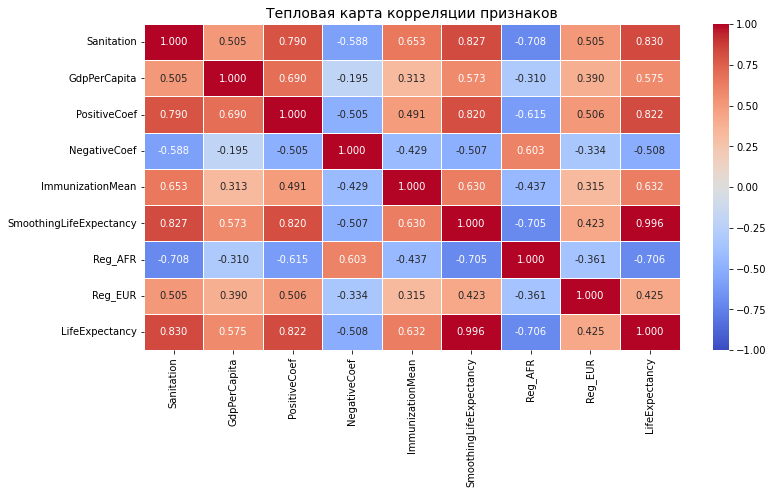

Посмотрим на пары признаков с коэффициентом корреляции больше, чем `0.7`

[(['Sanitation', 'PositiveCoef'], 0.79),
 (['Sanitation', 'SmoothingLifeExpectancy'], 0.83),
 (['Sanitation', 'Reg_AFR'], -0.71),
 (['Sanitation', 'LifeExpectancy'], 0.83),
 (['PositiveCoef', 'SmoothingLifeExpectancy'], 0.82),
 (['PositiveCoef', 'LifeExpectancy'], 0.82),
 (['SmoothingLifeExpectancy', 'LifeExpectancy'], 1.0),
 (['Reg_AFR', 'LifeExpectancy'], -0.71)]

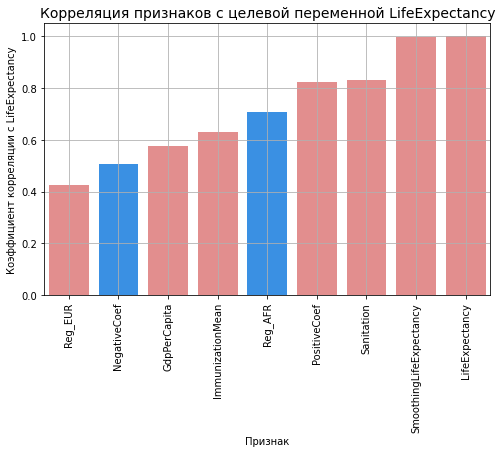

In [795]:
# Оставим в тренировочных данных оптимальные признаки
train_data_optimal = extract_optimal_features(train_data)

# Посмотрим на их корреляцию друг с другом и с целевой переменной
display_fields_correlation(
    train_data_optimal,
    matrix_figsize=(12, 6),
    barplot_figsize=(8, 5)
)

In [796]:
# Оставим в тренировочных и тестовых данных оптимальные признаки
train_data = extract_optimal_features(train_data)
test_data = extract_optimal_features(test_data)

# Разделим предикторы и таргет
X_train = train_data.drop(columns=[F.LifeExpectancy.value])
X_test = test_data.drop(columns=[F.LifeExpectancy.value])

y_train = train_data[F.LifeExpectancy.value]
y_test = test_data[F.LifeExpectancy.value]

# Перед масштабированием данных сохраним имена столбцов и индексы
columns = list(X_train.columns)
index_train = X_train.index
index_test = X_test.index

# Инициализируем нормализатор MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)

# Масштабируем данные
X_train = mm_scaler.transform(X_train)
# Добавим имена столбцов и индексы, которые потерялись при преобразовании
X_train = pd.DataFrame(X_train, columns=columns, index=index_train)

X_test = mm_scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

In [797]:
# Начинаем замерять время выполнения
start = time.time()

# Создаём объект класса LinearRegression
linear_regression_model = LinearRegression()

# Обучаем модель
linear_regression_model.fit(X_train, y_train) 

# Заканчиваем замерять время выполнения
end = time.time()
# Считаем общее время выполнения
exec_time = get_exec_time(start, end)

# Получаем предсказание
y_test_pred = linear_regression_model.predict(X_test)

# Метрика MAE для тестовой выборки
mae_test = mean_absolute_error(y_test, y_test_pred)

mae_test

0.5499923208438171